## 🔍 Descrição do Modelo: LSTM Autoencoder para HCPI

### 📌 Tipo de modelo
Este modelo é um **Autoencoder com LSTM** projetado para detectar padrões anómalos em séries temporais multivariadas. Foi implementado em **Keras (TensorFlow backend)** e estruturado da seguinte forma:
- Codificador: `LSTM(128)` → `RepeatVector`
- Decodificador: `LSTM(128)` → `TimeDistributed(Dense)`
- Reconstrói janelas de **12 meses × 168 países**, tentando prever a entrada original.

### 🧪 Técnicas utilizadas
- **Normalização Min-Max** por país (`MinMaxScaler` do `sklearn`).
- **Janelas deslizantes** de 12 meses aplicadas aos dados mensais:
  - Treino: janelas de 2010–2018
  - Teste: janelas de 2019–2020
- **Reconstrução temporal** com minimização do erro quadrático médio (MSE).
- **Detecção de anomalias** com base num limiar adaptativo:
  - `threshold = Q3 + 1.5 × IQR` dos erros de reconstrução no treino
  - Janelas com erro acima deste limiar são sinalizadas como anómalas.

### 📈 Variáveis utilizadas
- **HCPI_m** (Harmonised Consumer Price Index mensal) para todos os países com dados completos entre 2010 e 2020.
- Apenas países com pelo menos **132 observações mensais** foram incluídos (11 anos de dados).
- Total de **168 países** usados como variáveis (features).
- Nenhuma variável exógena adicional foi utilizada.

### 🔄 Versão e atualizações
Esta versão é uma atualização de um modelo anterior que tratava a série temporal como uma única sequência longa. As principais melhorias incluem:
- Uso de **janelas deslizantes** para melhor generalização e deteção local de desvios.
- Avaliação detalhada do erro por janela e por país.
- Cálculo automático de limiar de anomalia via estatística robusta (IQR).
- Inclusão de análise dos **países que mais contribuem para o erro de reconstrução**, permitindo diagnósticos mais específicos.



In [1]:
import pandas as pd

In [ ]:
hcpi = pd.read_parquet("data/hcpi_m.parquet")
hcpi.index = pd.to_datetime(hcpi.index)
hcpi.head()
df_period = hcpi.loc['2010-01-01':'2020-12-31']
df_period.head()

,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ATG,AUT,AZE,...,VCT,VEN,VGB,VNM,WSM,XKX,YEM,ZAF,ZMB,ZWE
2010-01-01,90.518,73.652677,18.297409,82.400000,88.008742,NaN,97.670572,86.417242,89.04379,97.2,...,100.0,166.5,NaN,58.542273,90.343792,87.955386,110.846000,75.30460,105.0,1.871011
2010-02-01,90.396,72.992480,18.459746,83.600000,87.859764,NaN,97.571898,86.617995,89.20885,98.3,...,100.1,169.1,NaN,59.689701,91.718191,88.191825,111.095000,75.77624,105.5,1.887481
2010-03-01,90.623,72.924208,18.654168,83.691822,87.943564,NaN,98.220672,86.596486,90.19913,99.6,...,100.2,173.2,NaN,60.137374,92.084697,88.113012,111.469000,76.40508,106.6,1.910539
2010-04-01,90.948,73.308250,18.845743,83.321715,87.915630,NaN,100.430178,86.854597,90.44671,99.6,...,100.9,182.2,NaN,60.221566,91.993070,87.246069,112.555864,76.40508,107.5,1.910539
2010-05-01,91.093,73.887146,19.045094,83.691822,87.850452,NaN,100.332465,87.456858,90.52924,99.5,...,100.8,187.0,NaN,60.384165,92.084697,87.482508,113.124000,76.56229,107.7,1.917127


### Verificação dos dados

In [ ]:
hcpi_period = hcpi.loc['2010-01-01':'2020-12-31']

# Verificar países com dados completos no período (132 meses)
min_required_months = 132
valid_countries = [col for col in hcpi.columns if hcpi_period[col].count() >= min_required_months]

# Separar dados de treino (2010–2018) e teste (2019–2020)
train = hcpi.loc['2010-01-01':'2018-12-31', valid_countries]
test = hcpi.loc['2019-01-01':'2020-12-31', valid_countries]

# (Opcional) Se quiseres ver as datas como coluna
train_reset = train.reset_index()

# Mostrar resultado
print("Dados de treino e teste separados com sucesso!")
print("Número de países válidos:", len(valid_countries))
# Exibir as formas dos DataFrames
print("Forma do DataFrame de treino:", train.shape)
print("Forma do DataFrame de teste:", test.shape)
# Exibir os países válidos
print("Países válidos:", valid_countries)


train.shape, test.shape, valid_countries

Dados de treino e teste separados com sucesso!
Número de países válidos: 168
Forma do DataFrame de treino: (108, 168)
Forma do DataFrame de teste: (24, 168)
Países válidos: ['AFG', 'AGO', 'ALB', 'ARE', 'ARM', 'ATG', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BRN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COG', 'COL', 'CPV', 'CRI', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MNE', 'MNG', 'MOZ', 'MRT', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 

((108, 168),
 (24, 168),
 ['AFG',
  'AGO',
  'ALB',
  'ARE',
  'ARM',
  'ATG',
  'AUT',
  'AZE',
  'BDI',
  'BEL',
  'BEN',
  'BFA',
  'BGD',
  'BGR',
  'BHR',
  'BHS',
  'BIH',
  'BLR',
  'BOL',
  'BRA',
  'BRB',
  'BRN',
  'BWA',
  'CAF',
  'CAN',
  'CHE',
  'CHL',
  'CHN',
  'CIV',
  'CMR',
  'COG',
  'COL',
  'CPV',
  'CRI',
  'CYP',
  'CZE',
  'DEU',
  'DJI',
  'DMA',
  'DNK',
  'DOM',
  'DZA',
  'ECU',
  'EGY',
  'ESP',
  'EST',
  'FIN',
  'FJI',
  'FRA',
  'GAB',
  'GBR',
  'GEO',
  'GHA',
  'GIN',
  'GMB',
  'GNB',
  'GNQ',
  'GRC',
  'GRD',
  'GTM',
  'GUY',
  'HKG',
  'HND',
  'HRV',
  'HTI',
  'HUN',
  'IDN',
  'IND',
  'IRL',
  'IRN',
  'ISL',
  'ISR',
  'ITA',
  'JAM',
  'JOR',
  'JPN',
  'KAZ',
  'KEN',
  'KGZ',
  'KHM',
  'KIR',
  'KNA',
  'KOR',
  'KWT',
  'LAO',
  'LBN',
  'LBR',
  'LBY',
  'LCA',
  'LKA',
  'LSO',
  'LTU',
  'LUX',
  'LVA',
  'MAC',
  'MAR',
  'MDA',
  'MDG',
  'MDV',
  'MEX',
  'MKD',
  'MLI',
  'MLT',
  'MNE',
  'MNG',
  'MOZ',
  'MRT',
  'MSR',
  '

### Train/test split

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalização dos dados
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Função para criar janelas deslizantes
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i+window_size])
    return np.array(X)

# Tamanho da janela
window_size = 12

# Criar as janelas
X_train = create_sequences(train_scaled, window_size)
X_test = create_sequences(test_scaled, window_size)

# Formas resultantes
print("Forma de X_train:", X_train.shape)  # ex: (97, 12, 168)
print("Forma de X_test:", X_test.shape)    # ex: (13, 12, 168)


Forma de X_train: (97, 12, 168)
Forma de X_test: (13, 12, 168)


### Definição do modelo

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
repeat = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 168)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       152,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 12, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 168)        │        21,672 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,320 (1.16 MB)

 Trainable params: 305,320 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

### Treino

In [14]:
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=16,
                          validation_split=0.1,
                          verbose=1)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.2861 - val_loss: 0.5014
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1505 - val_loss: 0.2187
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0733 - val_loss: 0.1127
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0401 - val_loss: 0.0694
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0242 - val_loss: 0.0524
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0194 - val_loss: 0.0528
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0160 - val_loss: 0.0544
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0137 - val_loss: 0.0563
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0120 - val_loss: 0.0354
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0111 - val_loss: 0.0331
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097 - val_loss: 0.0317
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0092 - val_l

### Teste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


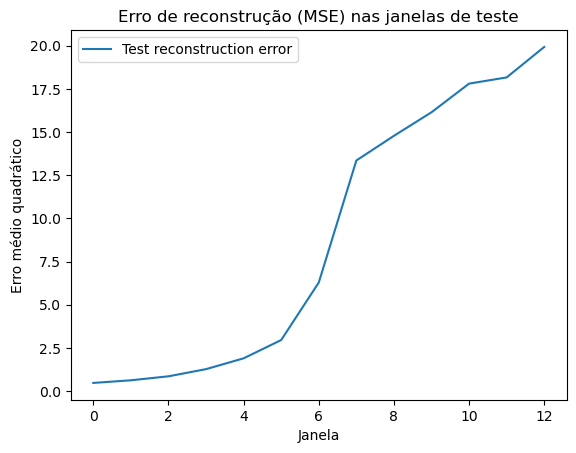

In [15]:
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.mean((X_test_pred - X_test) ** 2, axis=2), axis=1)  # MSE por janela

# (Opcional) Visualização
import matplotlib.pyplot as plt

plt.plot(mse_test, label="Test reconstruction error")
plt.title("Erro de reconstrução (MSE) nas janelas de teste")
plt.xlabel("Janela")
plt.ylabel("Erro médio quadrático")
plt.legend()
plt.show()


### Configuração do erro relativo ao threshold para identificação de anomalias

In [16]:
# Erro de reconstrução no treino
X_train_pred = autoencoder.predict(X_train)
mse_train = np.mean(np.mean((X_train_pred - X_train) ** 2, axis=2), axis=1)

# Calcular threshold com IQR
q1 = np.percentile(mse_train, 25)
q3 = np.percentile(mse_train, 75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr

print("Threshold de anomalia:", threshold)

# Detectar janelas anómalas no teste
anomalies = mse_test > threshold

# Resultados
for i, is_anomaly in enumerate(anomalies):
    status = "🚨 Anómala" if is_anomaly else "✓ Normal"
    print(f"Janela {i:2d}: Erro = {mse_test[i]:.4f} → {status}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 
Threshold de anomalia: 0.003318680842530445
Janela  0: Erro = 0.4691 → 🚨 Anómala
Janela  1: Erro = 0.6216 → 🚨 Anómala
Janela  2: Erro = 0.8525 → 🚨 Anómala
Janela  3: Erro = 1.2674 → 🚨 Anómala
Janela  4: Erro = 1.8940 → 🚨 Anómala
Janela  5: Erro = 2.9539 → 🚨 Anómala
Janela  6: Erro = 6.2848 → 🚨 Anómala
Janela  7: Erro = 13.3529 → 🚨 Anómala
Janela  8: Erro = 14.7812 → 🚨 Anómala
Janela  9: Erro = 16.1458 → 🚨 Anómala
Janela 10: Erro = 17.8051 → 🚨 Anómala
Janela 11: Erro = 18.1632 → 🚨 Anómala
Janela 12: Erro = 19.9302 → 🚨 Anómala


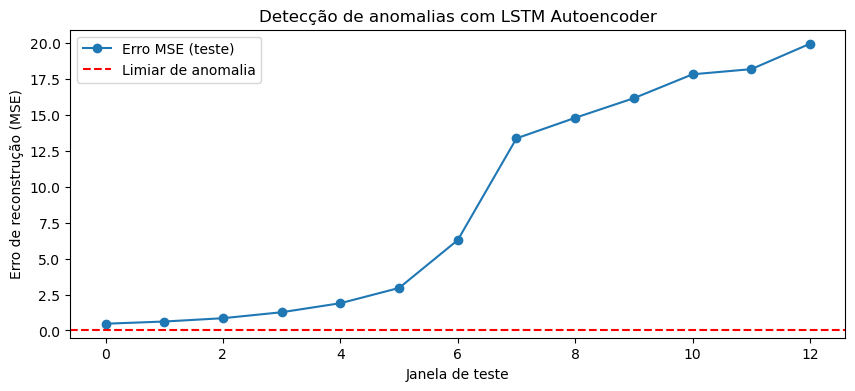

In [17]:
plt.figure(figsize=(10,4))
plt.plot(mse_test, marker='o', label="Erro MSE (teste)")
plt.axhline(threshold, color='r', linestyle='--', label="Limiar de anomalia")
plt.title("Detecção de anomalias com LSTM Autoencoder")
plt.xlabel("Janela de teste")
plt.ylabel("Erro de reconstrução (MSE)")
plt.legend()
plt.show()


### Mesmo que acima, mas com anos

In [18]:
# Obter datas do DataFrame de teste (índice datetime)
test_dates = test.index

# Datas de início de cada janela
window_starts = test_dates[:len(X_test)]

# Mostrar janelas anómalas com data
for i, (is_anomaly, date) in enumerate(zip(anomalies, window_starts)):
    status = "🚨 Anómala" if is_anomaly else "✓ Normal"
    print(f"Janela {i:2d} → Início: {date.strftime('%Y-%m')} → {status} (Erro = {mse_test[i]:.4f})")


Janela  0 → Início: 2019-01 → 🚨 Anómala (Erro = 0.4691)
Janela  1 → Início: 2019-02 → 🚨 Anómala (Erro = 0.6216)
Janela  2 → Início: 2019-03 → 🚨 Anómala (Erro = 0.8525)
Janela  3 → Início: 2019-04 → 🚨 Anómala (Erro = 1.2674)
Janela  4 → Início: 2019-05 → 🚨 Anómala (Erro = 1.8940)
Janela  5 → Início: 2019-06 → 🚨 Anómala (Erro = 2.9539)
Janela  6 → Início: 2019-07 → 🚨 Anómala (Erro = 6.2848)
Janela  7 → Início: 2019-08 → 🚨 Anómala (Erro = 13.3529)
Janela  8 → Início: 2019-09 → 🚨 Anómala (Erro = 14.7812)
Janela  9 → Início: 2019-10 → 🚨 Anómala (Erro = 16.1458)
Janela 10 → Início: 2019-11 → 🚨 Anómala (Erro = 17.8051)
Janela 11 → Início: 2019-12 → 🚨 Anómala (Erro = 18.1632)
Janela 12 → Início: 2020-01 → 🚨 Anómala (Erro = 19.9302)


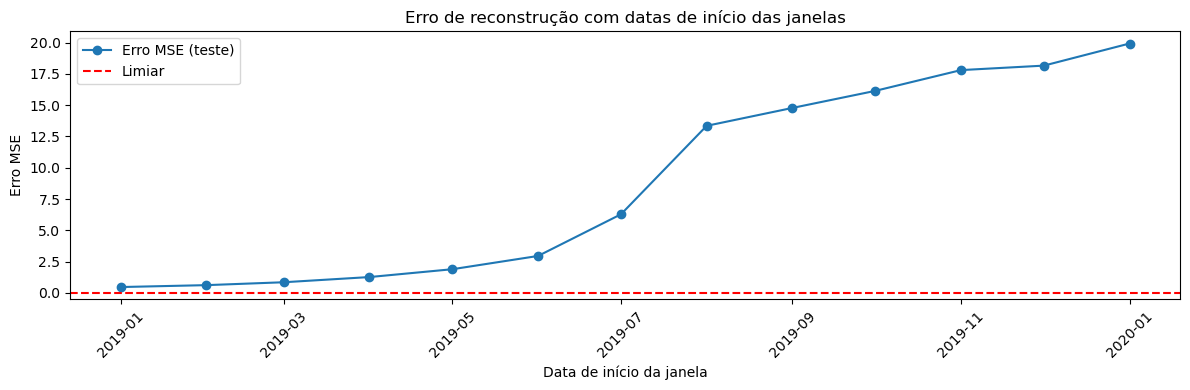

In [19]:
plt.figure(figsize=(12,4))
plt.plot(window_starts, mse_test, marker='o', label="Erro MSE (teste)")
plt.axhline(threshold, color='r', linestyle='--', label="Limiar")
plt.xticks(rotation=45)
plt.title("Erro de reconstrução com datas de início das janelas")
plt.xlabel("Data de início da janela")
plt.ylabel("Erro MSE")
plt.legend()
plt.tight_layout()
plt.show()


### Países que mais contribuem para o erro de reconstrução

In [20]:
import pandas as pd
import numpy as np

# Erro absoluto ao longo de todas as janelas e passos temporais
error_matrix = (X_test - X_test_pred) ** 2  # shape: (n_janelas, 12, 168)

# Erro médio por país (eixo 0 = janelas, eixo 1 = meses)
mean_error_per_country = np.mean(error_matrix, axis=(0, 1))  # shape: (168,)

# Converter para DataFrame legível
country_error = pd.Series(mean_error_per_country, index=train.columns)
country_error_sorted = country_error.sort_values(ascending=False)

# Mostrar os 10 países com mais erro de reconstrução
print(country_error_sorted.head(10))


ZWE    869.658289
LUX     26.468161
QAT     19.969867
CHL     19.098395
BEL     16.882306
BEN     16.421632
CMR     13.572292
ARM     12.521935
BRN     12.417027
BIH     12.066456
dtype: float64


<Axes: title={'center': 'Top 10 países com maior erro de reconstrução'}>

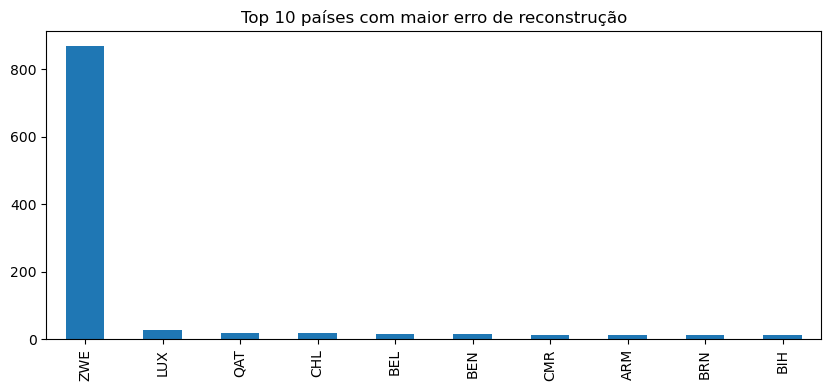

In [22]:
country_error_sorted.head(10).plot(kind='bar', figsize=(10,4), title="Top 10 países com maior erro de reconstrução")

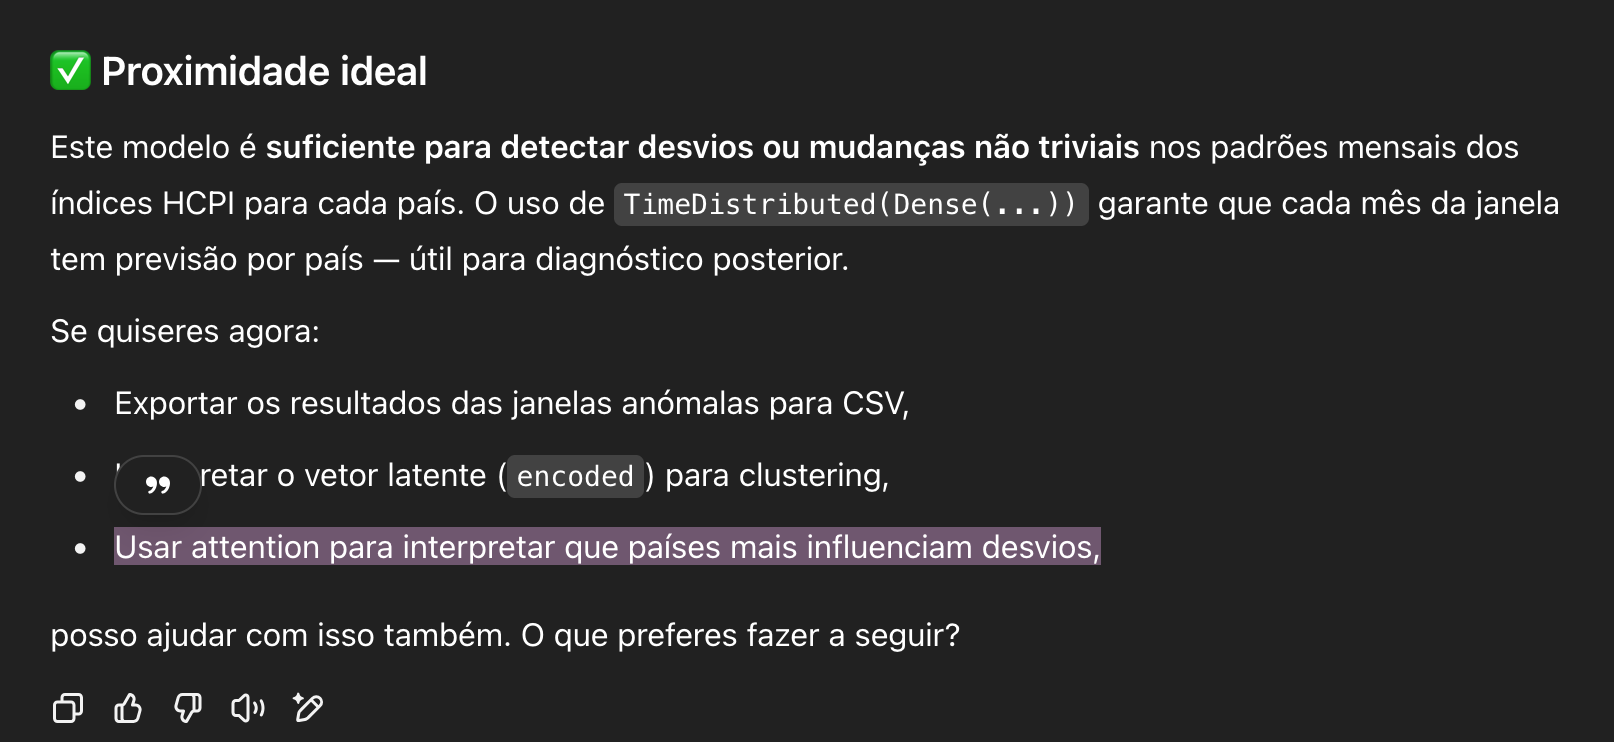